<a href="https://colab.research.google.com/github/sameerkulkarni/financial_simulations/blob/master/base_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Financial Simulations**

Measure different investment strategies

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
findata = pd.read_csv("https://raw.githubusercontent.com/sameerkulkarni/financial_simulations/master/returns.csv", sep=",")
# Add data of monthly rate of change in adj close.
findata['Scale'] = findata['Adj Close'].pct_change() +1
# Adjust the scale to inflation every month.
findata['Scale_InfAdj'] = findata['Scale'] - (findata['Inflation']/1200)
findata = findata.drop(['Open', 'High', 'Low'], axis=1)
fin_index = pd.Index(findata['Date'])

In [2]:
findata.loc[2:8]

,Date,Close,Adj Close,Inflation,Scale,Scale_InfAdj
2,1928-03-01,19.280001,19.280001,-1.16,1.117034,1.118000
3,1928-04-01,19.750000,19.750000,-1.16,1.024378,1.025344
4,1928-05-01,20.000000,20.000000,-1.15,1.012658,1.013617
5,1928-06-01,19.139999,19.139999,-2.84,0.957000,0.959367
6,1928-07-01,19.430000,19.430000,-1.16,1.015152,1.016118
7,1928-08-01,20.870001,20.870001,-0.58,1.074112,1.074596
8,1928-09-01,21.139999,21.139999,0.00,1.012937,1.012937


**One shot investment strategies**

The strategies below mimic the one time investments. e.g. If you have a pot of money that you need to invest into the market.

In [0]:
# Basic Strategy: Invest once; for the entire duration.
def calculate_returns(startpoint, duration):
  begin = findata.loc[startpoint]['Adj Close']
  end = findata.loc[startpoint+(duration*12)]['Adj Close']
  total_returns = 1+ ((end-begin)/begin)
  avg_returns = (total_returns**(1.0/duration))
  return avg_returns

# Secondary strategy: If the intended retirement would cause an average return
#   of less than expected_returns, then wait a max of extended_duration years
#   and retire as soon as it reaches expected_returns. If waiting does not reach
#   expected returns, retire at the end of the extended_duration.
def flexible_end_date(startpoint, duration, extended_duration=2, expected_returns=1.065):
  begin = findata.loc[startpoint]['Adj Close']
  intended_end_month= startpoint+(duration*12)
  end = findata.loc[intended_end_month]['Adj Close']
  total_returns = 1+ ((end-begin)/begin)
  avg_returns = (total_returns**(1.0/duration))
  # print("%2d, %2d, %3.3f, %3.3f, %1.3f, %1.3f" %(startpoint, intended_end_month, begin, end, total_returns, avg_returns))
  if (avg_returns > expected_returns):
    return avg_returns
  for i in range(intended_end_month,intended_end_month+(extended_duration*12)):
    end = findata.loc[i]['Adj Close']
    total_returns= 1+ ((end-begin)/begin)
    avg_returns = (total_returns**(1.0/((i-startpoint)/12)))
    # print("%2d, %2d, %3.3f, %3.3f, %1.3f, %1.3f" %(startpoint, i, begin, end, total_returns, avg_returns))
    if avg_returns >= expected_returns:
      return avg_returns
  return avg_returns

# Capped Gains Strategy: Here your returns are capped between [0,9] on a yearly 
# basis.
def capped_gains_strategy(startpoint, duration):
  returns=[]
  for i in range(0,duration):
    start_month=startpoint +(i*12)
    end_month=startpoint +((i+1)*12)
    begin = findata.loc[start_month]['Adj Close']
    end = findata.loc[end_month]['Adj Close']
    yearly_return = 1+ ((end-begin)/begin)
    if yearly_return < 1:
      yearly_return = 1
    if yearly_return > 1.095:
      yearly_return = 1.095
    returns.append(yearly_return)
  # print(returns)
  avg_returns = np.average(returns)
  return avg_returns

1.0706383718281038


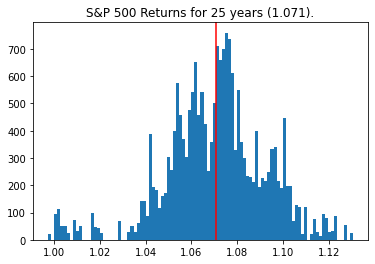

In [39]:
num_years = 25 #@param {type:"slider", min:1, max:60, step:1.0}
num_samples=20000
start_points=[random.randint(0,(92-num_years)*12) for i in range(num_samples)]
yearly_returns = [calculate_returns(start_points[i],num_years) for i in range(len(start_points))]
avg2_returns=np.average(yearly_returns)
print(avg2_returns)
plt.hist(yearly_returns, bins=100)
plt.title("S&P 500 Returns for %d years (%1.3f)."%(num_years,avg2_returns))
plt.axvline(avg2_returns,color='r')
plt.show()

1.0725421867797778


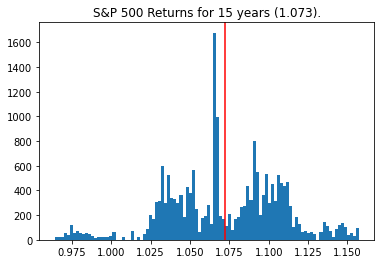

In [55]:
num_years = 13 #@param {type:"slider", min:1, max:60, step:1.0}
flexible_years = 3 #@param {type:"slider", min:0, max:15, step:1.0}
num_samples=20000
start_points=[random.randint(0,(92-(num_years+flexible_years))*12) for i in range(num_samples)]
yearly_returns = [flexible_end_date(start_points[i],num_years,flexible_years) for i in range(len(start_points))]
avg2_returns=np.average(yearly_returns)
print(avg2_returns)
plt.hist(yearly_returns, bins=100)
plt.title("S&P 500 Returns for %d years (%1.3f)."%(num_years,avg2_returns))
plt.axvline(avg2_returns,color='r')
plt.show()

1.0569217215049753


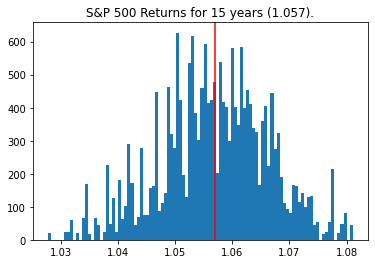

In [70]:
num_years = 15 #@param {type:"slider", min:1, max:60, step:1.0}
num_samples=20000
start_points=[random.randint(0,(92-num_years)*12) for i in range(num_samples)]
yearly_returns = [capped_gains_strategy(start_points[i],num_years) for i in range(len(start_points))]
avg2_returns=np.average(yearly_returns)
print(avg2_returns)
plt.hist(yearly_returns, bins=100)
plt.title("S&P 500 Returns for %d years (%1.3f)."%(num_years,avg2_returns))
plt.axvline(avg2_returns,color='r')
plt.show()

In [0]:
def current_return(month, investment_type=0):
  #  investment_type: 0=s&p500, 1=capped_s&p500, 2=bank, 3=bonds(tbd)
  if investment_type == 1:
    return max(1, min((1+(.09/12)), findata.loc[month]['Scale_InfAdj']))
  if investment_type == 2:
    return (1.0 - (findata.loc[month]['Inflation']/1200))
  return findata.loc[month]['Scale_InfAdj']

# Regular investment
def future_value(initial_amount, investment_amount, num_months, start_month, investment_type=0):
  #  initial_amount: Initial amount to start the investment with.
  #  investment_amount: Amount to be invested every month.
  #  num_months: Number of months to invest.
  #  start_month: When do you start investing the money.
  #  investment_type: 0=s&p500, 1=capped_s&p500, 2=bank, 3=bonds(tbd)
  current_amount=initial_amount
  for i in range(start_month, (start_month+num_months)):
    current_amount+=investment_amount
    current_amount*=current_return(i, investment_type)
  return current_amount

def weighted_return(initial_rampup_duration, initial_amount, total_duration, trickle_invest, start_month, investment_type=0):
  # initial_rampup_horizon: Number of months to split the initital investment time.
  # initial_amount: Total amount in units to be invested initially.
  # total_horizon: Total investment horizon.
  # trickle_invest: 
  investment_during_rampup = (initial_amount/initial_rampup_duration)+trickle_invest
  amount_after_initial_rampup=future_value(0,investment_during_rampup,initial_rampup_duration,start_month, investment_type)
  final_amount=future_value(amount_after_initial_rampup, trickle_invest, total_duration-initial_rampup_duration, start_month+initial_rampup_duration, investment_type)
  return final_amount

**Simulation Start Investing**

Here the person would have X dollars to invest at present, and would add some small amount every month for the given number of months.



1689.8571039602473


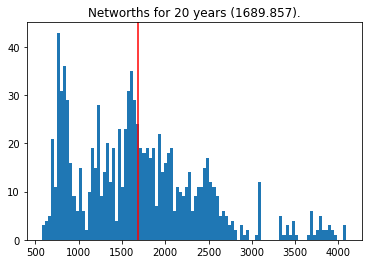

In [37]:
num_years = 20 #@param {type:"slider", min:1, max:60, step:1.0}
num_samples=1000
initial_rampup_months=6 #@param {type:"slider", min:1, max:60, step:1.0}
initial_amount=100 #@param {type:"slider", min:10, max:200, step:1.0}
trickle_invest=4 #@param {type:"slider", min:1, max:100, step:1.0}
start_points=[random.randint(1,(92-num_years)*12) for i in range(num_samples)]
final_networths = [weighted_return(initial_rampup_months, initial_amount, (num_years*12), trickle_invest, start_points[i],investment_type=0) for i in range(len(start_points))]
avg_nw=np.average(final_networths)
print(avg_nw)
plt.hist(final_networths, bins=100)
plt.title("Networths for %d years (%1.3f)."%(num_years,avg_nw))
plt.axvline(avg_nw,color='r')
plt.show()

1253.9324809270963


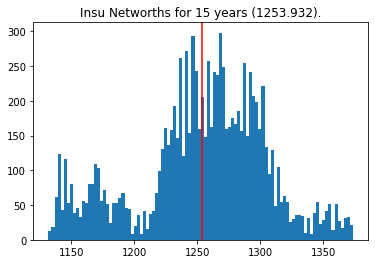

In [27]:
num_years = 15 #@param {type:"slider", min:1, max:60, step:1.0}
num_samples=10000
initial_rampup_months=6 #@param {type:"slider", min:1, max:60, step:1.0}
initial_amount=100 #@param {type:"slider", min:10, max:200, step:1.0}
trickle_invest=4 #@param {type:"slider", min:1, max:100, step:1.0}
start_points=[random.randint(1,(92-num_years)*12) for i in range(num_samples)]
final_networths = [weighted_return(initial_rampup_months, initial_amount, (num_years*12), trickle_invest, start_points[i]) for i in range(len(start_points))]
avg_nw=np.average(final_networths)
print(avg_nw)
plt.hist(final_networths, bins=100)
plt.title("Insu Networths for %d years (%1.3f)."%(num_years,avg_nw))
plt.axvline(avg_nw,color='r')
plt.show()

In [4]:
#  Bear Markets finder (more than 20% drop from the previous high)
#  https://www.investopedia.com/terms/b/bearmarket.asp
#  Top 11 Bear market dates = http://www.nbcnews.com/id/37740147/ns/business-stocks_and_economy/t/historic-bear-markets/#.XoCWDzdKh24

bear_market_dates=['1929-09-01', '1946-05-01', '1961-12-01', '1968-11-01', '1973-01-01', '1980-11-01', '1987-08-01', '2000-03-01', '2007-10-01']
bear_market_months=[fin_index.get_loc(bear_date) for bear_date in bear_market_dates]
print(bear_market_months)

[20, 220, 407, 490, 540, 634, 715, 866, 957]


In [17]:
num_years = 16 #@param {type:"slider", min:1, max:60, step:1.0}
initial_rampup_months=4 #@param {type:"slider", min:1, max:60, step:1.0}
initial_amount=100 #@param {type:"slider", min:10, max:200, step:1.0}
trickle_invest=4 #@param {type:"slider", min:1, max:100, step:1.0}
month_offset=-1
start_points=[month+month_offset for month in bear_market_months[:8]]
print(start_points)

#  investment_type: 0=s&p500, 1=capped_s&p500, 2=bank, 3=bonds(tbd)
for toi in [0,1,2]:
  tinvest = trickle_invest
  if toi == 1:
    tinvest-=1
  final_networths = [weighted_return(initial_rampup_months, initial_amount, (num_years*12), tinvest, start_points[i], toi) for i in range(len(start_points))]
  # final_networths = np.sort(final_networths)
  avg_nw=np.average(final_networths)
  med_nw=np.median(final_networths)
  print(toi, avg_nw, med_nw, final_networths)


[19, 219, 406, 489, 539, 633, 714, 865]
0 1166.6052938820776 1099.8615653926404 [877.3053398632773, 1876.1733826740108, 574.7691209891454, 728.7899483722488, 1098.2769858260012, 1803.490624515018, 1272.5908038576388, 1101.4461449592798]
1 1062.450461622364 1077.4632927015982 [1056.0735378731868, 1098.8530475300097, 981.2535864258048, 992.9174516352301, 1035.7625446965653, 1132.555825308484, 1100.7923255739763, 1101.3953739356552]
2 634.8063713552949 662.5546898351404 [729.4725254596896, 723.2503622120511, 541.281740486041, 479.0756780765288, 547.3397194008145, 638.561324743615, 686.5480549266657, 732.9215655369535]
